# Burger equation in 1D: joint estimation (vanilla inverse problem)

Consider the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\nu$. To do so we follow the methodology straightforward methodology from _Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations_, Raissi et al., 2019, i.e., we minimize the dynamic loss with respect to both the neural network parameters and the equation parameters. We also make use of a batch of available observations. See more explanation at [this page](https://hgangloff.pages.mia.inra.fr/pinn_experiments/param_estim_pinn.html)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)


## Observations

We use artificial observations from the estimated solution from the other notebook on Burger equation.

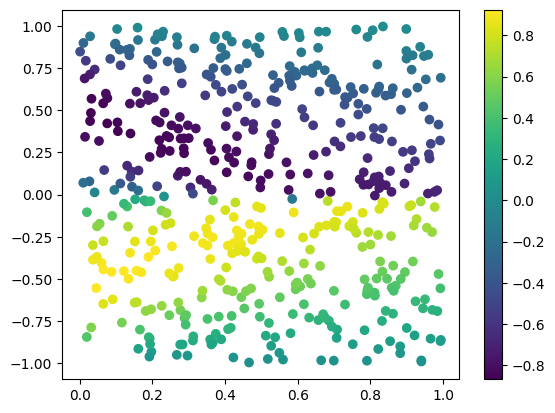

In [5]:
observations = jnp.load("burger_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 500
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=False
)
key, subkey = jax.random.split(key)
size_subsample = 500
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=False
)
obs_batch = observations[
    time_subsample,
    omega_subsample
]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


__Optionally blur the observed values__

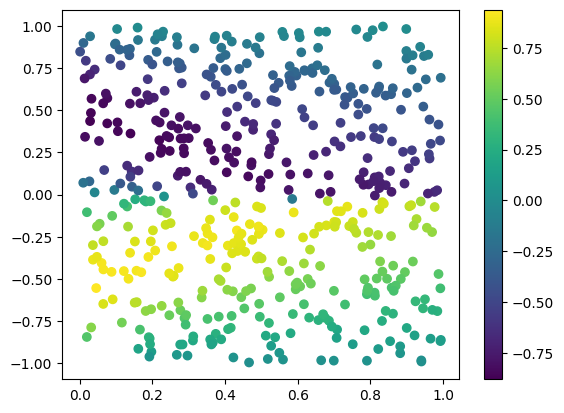

In [6]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


Create the neural network architecture for the PINN with `equinox`. Note that we want the entry of the PINN to be composed of 3 elements: `t`, `x` and `nu` (the Bruger equation's parameter). To do so, we create an input transform function for the PINN that plays the role of concatenating the `nu` to `t` and `x`. We know from reading the documentation that an `input_transform` has 2 parameters:

- `t_x`, i.e., `t` and `x` concatenated in the case of non-stationary equations
- `params` the main dictionary of parameters (that we will define below in this notebook)

from that, we can define an PINN entry that accepts the some other parameters of the model.

In [7]:
eqx_list = [
    [eqx.nn.Linear, 3, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1]
]
def input_transform(t_x, params):
    t_x_params = jnp.concatenate([t_x, params["eq_params"]["nu"]], axis=-1)
    return t_x_params
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1, input_transform=input_transform)
init_nn_params = u.init_params()

Create a DataGenerator object

In [8]:
n = 500
nt = 500
nb = 2
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


## Model parameters

__Optionally blur the initial parameter value__

In [9]:
# True is : nu = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
nu_ori = jnp.array([1 / (100 * jnp.pi)])
print(nu_ori)
nu = nu_ori + random.normal(subkey, shape=(1,)) * 0.001
print(nu)


[0.0031831]
[0.00390729]


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}


## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

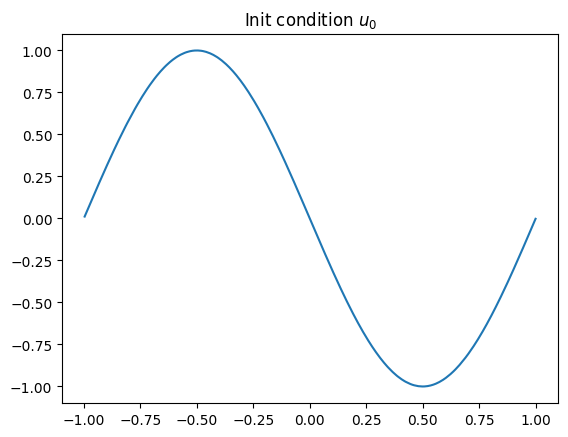

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")


## Loss construction

**NOTE**: with the `derivative_keys` parameter we tell with respect to which parameter(s) of `params` we want to compute the gradients, for each loss terms. A loss term that is not mentioned in the `derivative_keys` dictionary is by default derived with respect to `nn_params` ($\nu$) only. Such considerations are still an active research topic, as well as the optimization schedule to define for the estimation of `nn_params` ($\nu$) and `eq_params` ($\theta$). See below for the setting of the optimization process.

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":1, "boundary_loss":1, "observations":1e1}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    derivative_keys={
        "dyn_loss":["nn_params"],
        "observations":["nn_params", "eq_params"]
    }, # all others loss_term entries will be ["nn_params"]
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    obs_batch=[obs_batch[:, 0], obs_batch[:, 1], obs_batch[:, 2]]
)


In [14]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 3.95
Individual losses: {'boundary_loss': '0.01', 'dyn_loss': '0.00', 'initial_condition': '0.58', 'norm_loss': '0.00', 'observations': '3.37', 'sobolev': '0.00'}


## Joint estimation of `eq_params` and `nn_params`

In [15]:
params = init_params


Below we can test either the alternating optimizer or the delayed optimizer provided by `jinns` to alter the optimization process whether we consider the PINN parameters or the equation parameters.

In [16]:
import optax
n_iter = 250000
evry = 2500
delay_steps = 10000

tx1 = optax.adam(learning_rate=1e-4)
tx2 = optax.adam(learning_rate=1e-7)

tx = jinns.utils.alternate_optimizer(["nn_params"], ["nu"], n_iter, evry, tx1, tx2)
#tx = jinns.utils.delayed_optimizer(["nn_params"], ["nu"], delay_steps, tx1, tx2)

Next we define which parameter we want to track. For each one we give a list of keys that correspond to the path of the parameter in `params`

In [17]:
tracked_params_key_list = [
    ['eq_params', 'nu']
]

Then optimization starts

In [18]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params = jinns.solve(
    init_params=params,
    data=train_data,
    tracked_params_key_list=tracked_params_key_list,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000
)

Iteration 0: loss value = 3.9444966316223145


  0%|          | 0/250000 [00:00<?, ?it/s]

Iteration 10000: loss value = 0.32772761583328247
Iteration 20000: loss value = 0.21130380034446716
Iteration 30000: loss value = 0.1118878573179245
Iteration 40000: loss value = 0.07062608003616333
Iteration 50000: loss value = 0.047931965440511703
Iteration 60000: loss value = 0.038647256791591644
Iteration 70000: loss value = 0.0416710302233696
Iteration 80000: loss value = 0.03057255782186985
Iteration 90000: loss value = 0.022328898310661316
Iteration 100000: loss value = 0.03897619619965553
Iteration 110000: loss value = 0.02739100344479084
Iteration 120000: loss value = 0.02277589961886406
Iteration 130000: loss value = 0.02676926553249359
Iteration 140000: loss value = 0.041281670331954956
Iteration 150000: loss value = 0.01957608573138714
Iteration 160000: loss value = 0.019987478852272034
Iteration 170000: loss value = 0.01709991879761219
Iteration 180000: loss value = 0.020538579672574997
Iteration 190000: loss value = 0.017384452745318413
Iteration 200000: loss value = 0.02

## Results

Plot the tracked parameters

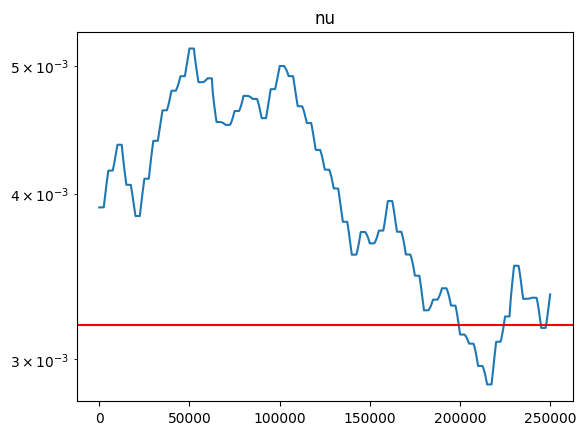

In [19]:
colors = ['blue']
plt.semilogy(tracked_params[tracked_params_key_list[0][0]][tracked_params_key_list[0][1]])
plt.axhline(y=nu_ori, color='r', linestyle='-')
plt.title(f"nu")
plt.show()


In [20]:
params["eq_params"]["nu"]

Array([0.0033592], dtype=float32)

Plot the loss values

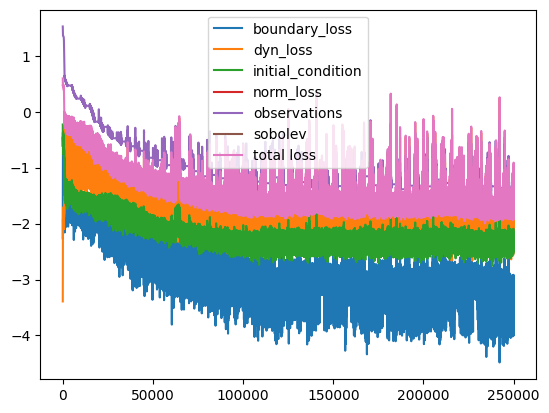

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

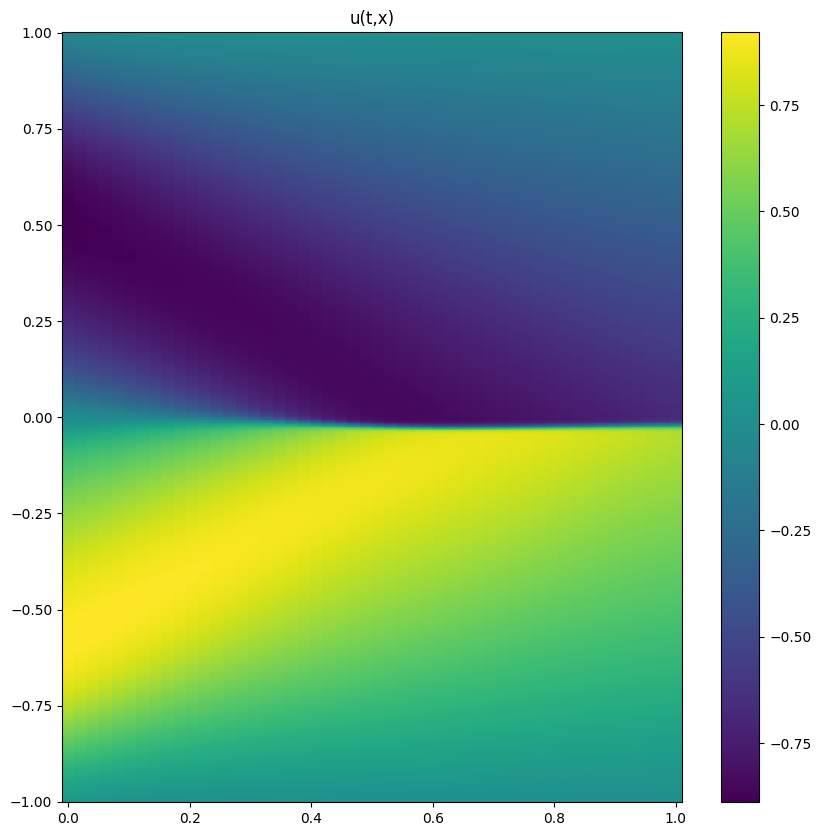

In [22]:
u_est = partial(u, params=params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t,x)")


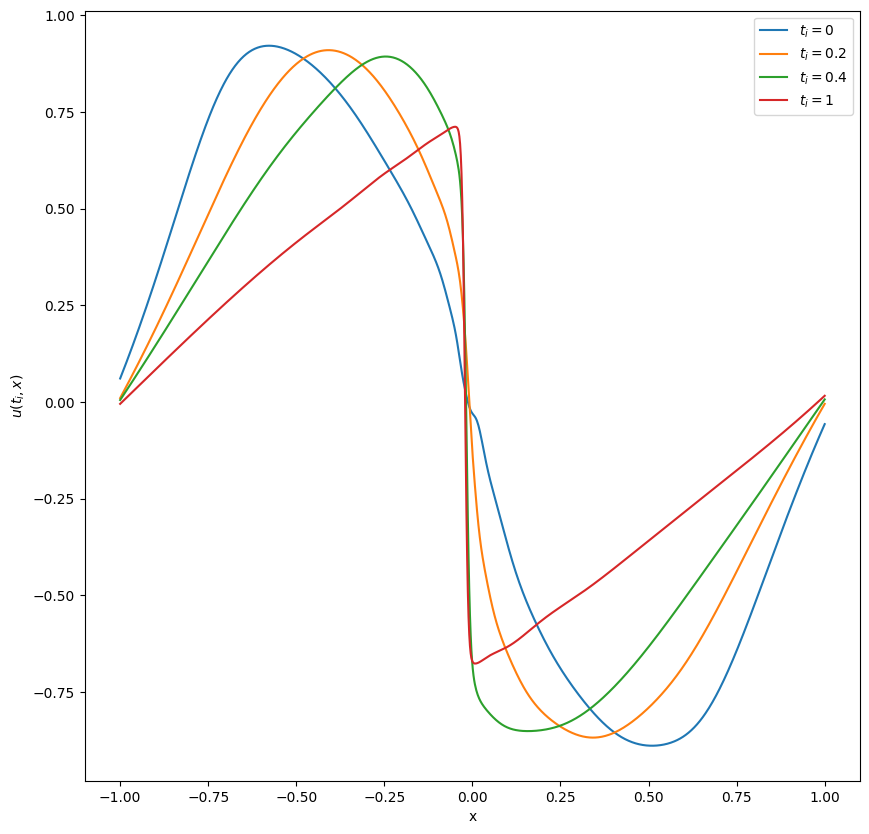

In [23]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)
